In [116]:
import tensorflow as tf
import os

import cv2 
from PIL import Image
import imghdr
import numpy as np
from matplotlib import pyplot as plt


In [117]:
#Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

First we need to clean the data, and remove anything that is not an image.

In [118]:
data_dir = 'data'
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)

            if tip not in image_exts:
                print("Image ext not in list {}".format(image_path))
                print("tip: {}".format(tip))
                os.remove(image_path)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

Image ext not in list data\greens\green-jade-shrimp-2.webp
tip: webp
Image ext not in list data\oranges\neocaridina-orange-sunkist-nascapers.webp
tip: webp
Image ext not in list data\oranges\nlrUq0AH.webp
tip: webp
Image ext not in list data\oranges\orange-rili-shrimp1.webp
tip: webp
Image ext not in list data\oranges\orange-rili-shrimp2.webp
tip: webp
Image ext not in list data\oranges\orange-sunkist-1.webp
tip: webp
Image ext not in list data\oranges\s-l12002.webp
tip: webp


This how we display images, note we have to change the color because it reads it in as BGR instead of RGB.

In [5]:
# img = cv2.imread(os.path.join('data','blue_dreams','48b0ca_c3c6ed33d29d4d3db6229f8edb345e5emv2.jpg'))

#plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Once the data is cleaned, we load the data into a data variable.

In [119]:
data = tf.keras.utils.image_dataset_from_directory('data')


Found 2153 files belonging to 4 classes.


These commented out blocks of code can be used to visualize the data. The min and max of the batch should be between 0 and 1 after scaling and 0 and 255 before scaling

In [62]:
# data_iterator = data.as_numpy_iterator()
# batch = data_iterator.next()

In [ ]:
# Class 0 = Blue Dreams
#Class 1 = Cherry Shrimp
# batch[0].max()
# batch[0].min()

We re-initalize the data and scale it using lambda to cut down the size of the images

In [120]:
data = data.map(lambda x,y: (x/255, y))

We create an iterator to go through the data

In [121]:
scaled_iterator = data.as_numpy_iterator()

In [124]:
batch = scaled_iterator.next()

We can now print them out to see what the images look like. This is to verify that the images are being scaled correctly with the correct color. 
0 = Blue, 1 = Green 2 = Oranges, 3 = red 

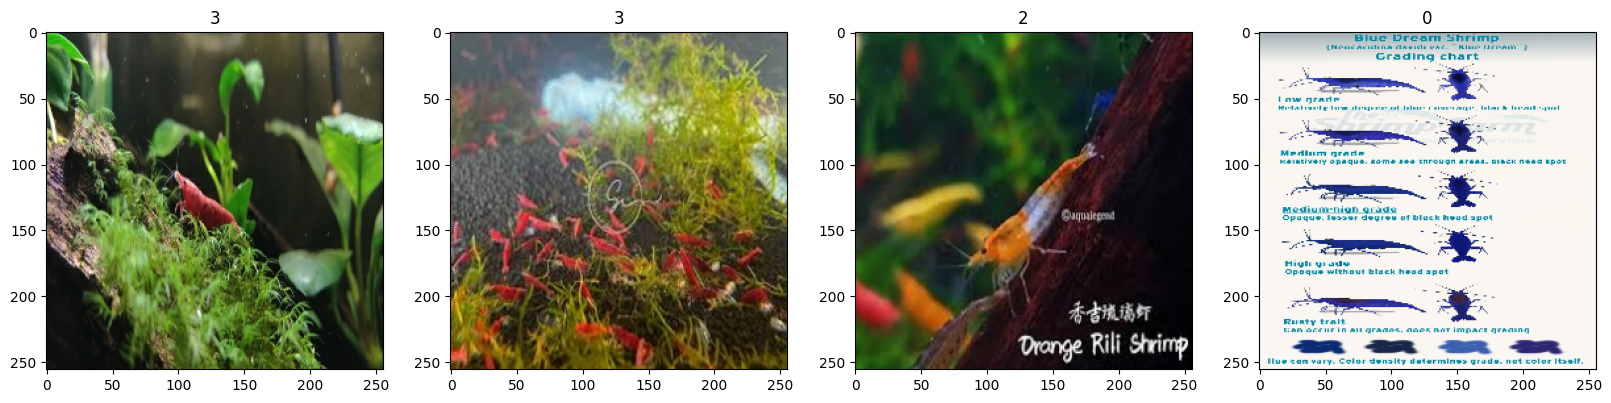

In [125]:
fig, ax = plt.subplots(ncols=4)
fig.set_size_inches(20,20)
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])

We create the train, validation, and test sets.

In [136]:
train_size = int(len(data)*.7)
validation_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1


train = data.take(train_size)
validation = data.skip(train_size).take(validation_size)
test = data.skip(train_size+validation_size).take(test_size)


Extra with InceptionV3, we need to break up the data into x and y sets

In [139]:
# Extract input features (X) and target labels (y) from the training set
X_train = train.map(lambda x, y: x)
y_train = train.map(lambda x, y: y)
train = tf.data.Dataset.zip((X_train, y_train))
# Extract input features (X) and target labels (y) from the validation set
X_validation = validation.map(lambda x, y: x)
y_validation = validation.map(lambda x, y: y)
validation = tf.data.Dataset.zip((X_validation, y_validation))

# Extract input features (X) and target labels (y) from the test set
X_test = test.map(lambda x, y: x)
y_test = test.map(lambda x, y: y)
test = tf.data.Dataset.zip((X_test, y_test))


The length and the test size of the data should be the same. This is to verify that the data is being split correctly.

In [127]:
len(data)

68

In [128]:
test_size + validation_size + train_size

68

In [129]:
# from tensorflow.keras.models import Functional This is probably what I want to use for multiple input and output types
from tensorflow.keras.models import Sequential # 1 data in 1 data out, flows top to bottom
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model 
import tensorflow as tf

We import our models and layers to apply to the model.

In [130]:
input_shape = (256, 256, 3)
base_model = tf.keras.applications.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet', pooling='avg')
base_model.trainable = False

num_classes = 4

output_layer = Dense(num_classes, activation='softmax')

model = Model(inputs=base_model.input, outputs=output_layer(base_model.output))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [142]:
targets = [[0, 0, 0, 0], [1, 1, 1, 1], [2, 2, 2, 2], [3, 3, 3, 3]]

Code bellow was used for a sequential model, I am now swapping over to InceptionV3

In [104]:
# model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation='relu', input_shape=(256, 256, 3)))
# model.add(MaxPooling2D())

# model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))



C:\Users\thovu\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


We compile the model and verify that the model is working correctly.

In [131]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [ ]:
# model.summary()

Create a callback and plug it into our fit function.
epochs is the number of times the model will go through the data. This should scale with the amount of data we have.

In [134]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [143]:
# hist = model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])
history = model.fit(train, epochs=50, validation_data=[validation, targets], callbacks=[tensorboard_callback, early_stopping_callback])

Epoch 1/50


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 4)

We use plt to visualize the loss and accuracy of the model.

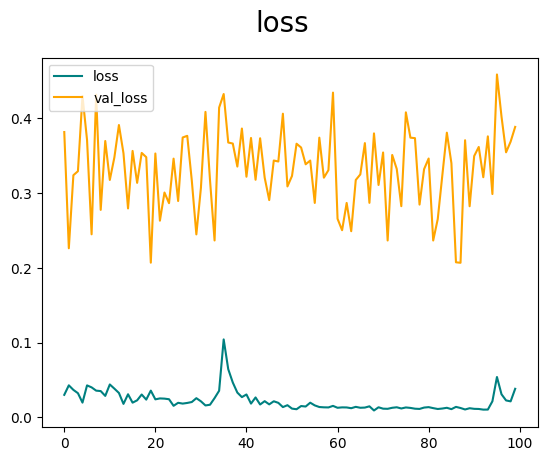

In [111]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

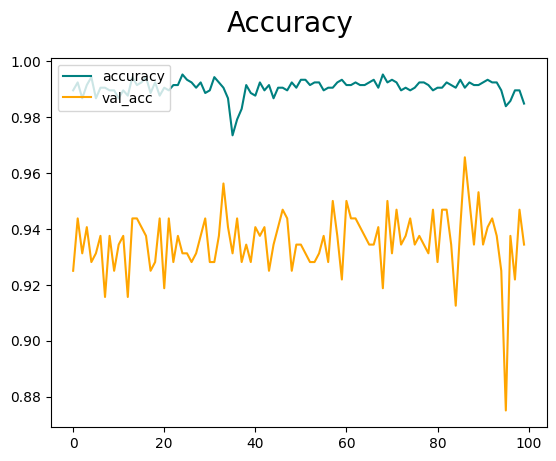

In [113]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_acc')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()